### Import modules

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils import constants

### Load data

In [2]:
segmentations_df = pd.read_csv(constants.RAW_METADATA_PATH)

### Explore data

In [10]:
segmentations_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [11]:
segmentations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


In [12]:
print(f"Shape of the dataframe: {segmentations_df.shape}")

Shape of the dataframe: (231723, 2)


#### Explore NaNs

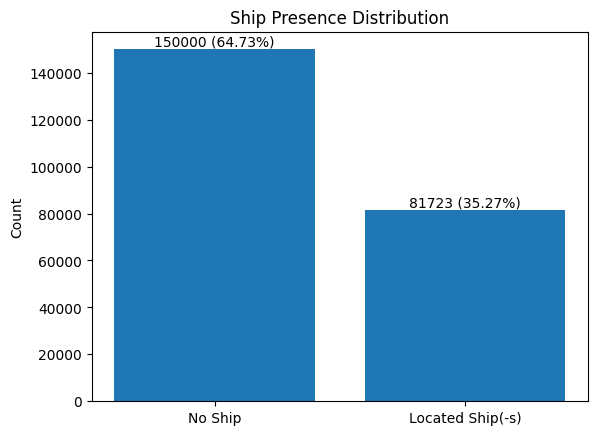

In [13]:
# Count the number of null and non-null values in the column "EncodedPixels"
nan_distribution_df = segmentations_df['EncodedPixels'].isnull().value_counts()

# Map the boolean values to strings
nan_distribution_df.index = nan_distribution_df.index.map({True: 'No Ship', False: 'Located Ship(-s)'})

# Calculate the percentage of null and non-null values
total_count = nan_distribution_df.sum()
percentage = nan_distribution_df / total_count * 100

# Plot the counts and percentages
fig, ax = plt.subplots()
ax.bar(nan_distribution_df.index.astype(str), nan_distribution_df.values, label='Count')
ax.set_ylabel('Count')
ax.set_title('Ship Presence Distribution')

# Add numbers and percentages on the bars
for i, (v, p) in enumerate(zip(nan_distribution_df.values, percentage.values)):
    ax.text(i, v, f"{v} ({p:.2f}%)", ha='center', va='bottom')

plt.show()


#### Located Ships per Image Distribution

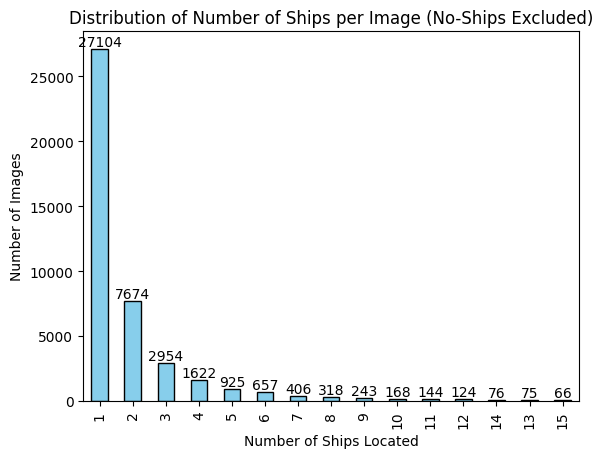

In [14]:
# Add a 'ship_located' column
segmentations_df['ship_located'] = segmentations_df['EncodedPixels'].map(lambda c_row: True if isinstance(c_row, str) else False)

# Count the number of ships per image and add a 'ship_count' column
grouped_segmentations_df = segmentations_df.groupby('ImageId').agg({'ship_located': 'sum'}).reset_index()
grouped_segmentations_df.rename(columns={'ship_located': 'ship_count'}, inplace=True)

# Count the number of images per number of ships
ship_counts_df = grouped_segmentations_df[grouped_segmentations_df["ship_count"] > 0]['ship_count'].value_counts()

# Create a bar plot
ship_counts_df.plot(kind='bar', color='skyblue', edgecolor='black')

# Add the number of images for each number of ships above the corresponding bar
for i, value in enumerate(ship_counts_df):
    plt.text(i, value, str(value), ha = 'center', va = 'bottom')
    
# Setting the title and labels
plt.title('Distribution of Number of Ships per Image (No-Ships Excluded)')
plt.xlabel('Number of Ships Located')
plt.ylabel('Number of Images')

# Displaying the plot
plt.show()

#### Explore the images and annotated masks

In [25]:
def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode the RLE-encoded mask and return a binary mask
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def show_image_with_n_ships(n, segmentations_df, grouped_segmentations_df):
    # Get the first image with n ships
    n_ships_df = grouped_segmentations_df[grouped_segmentations_df['ship_count'] == n]
    image_id = n_ships_df.iloc[0]['ImageId']

    # Load the image
    img = cv2.imread(os.path.join(constants.RAW_TRAIN_IMAGES_DIR, image_id))

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the image on the first subplot
    axs[0].imshow(img)
    axs[0].set_title('Image')

    if n != 0:
        # Get the RLE strings for this image
        masks = segmentations_df.loc[segmentations_df['ImageId'] == image_id, 'EncodedPixels']

        # Create an empty mask and add all the ships
        total_mask = np.zeros((768, 768))
        for mask in masks:
            total_mask += rle_decode(mask)

        # Plot the mask on the second subplot
        axs[1].imshow(total_mask, cmap='gray')
        axs[1].set_title('Mask')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()


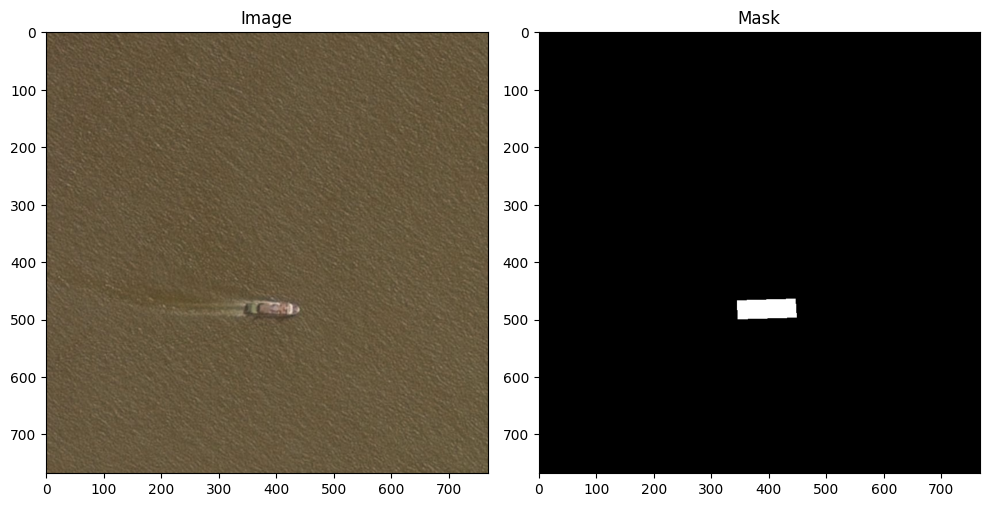

In [26]:
show_image_with_n_ships(1, segmentations_df, grouped_segmentations_df)

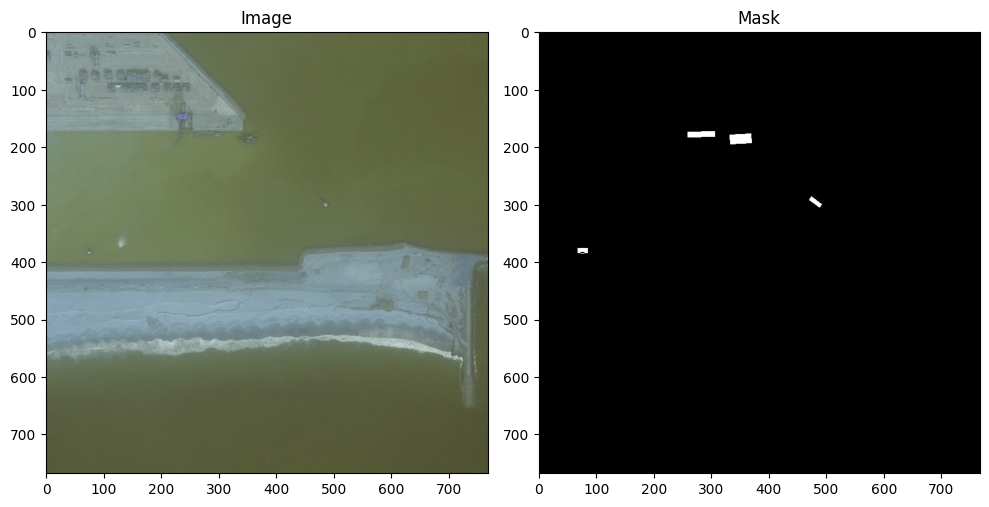

In [27]:
show_image_with_n_ships(5, segmentations_df, grouped_segmentations_df)

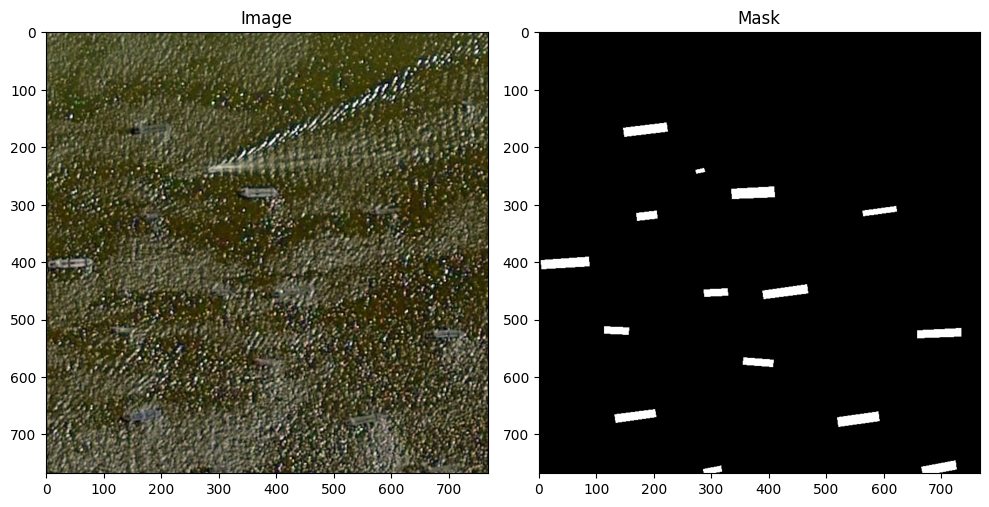

In [28]:
show_image_with_n_ships(15, segmentations_df, grouped_segmentations_df)

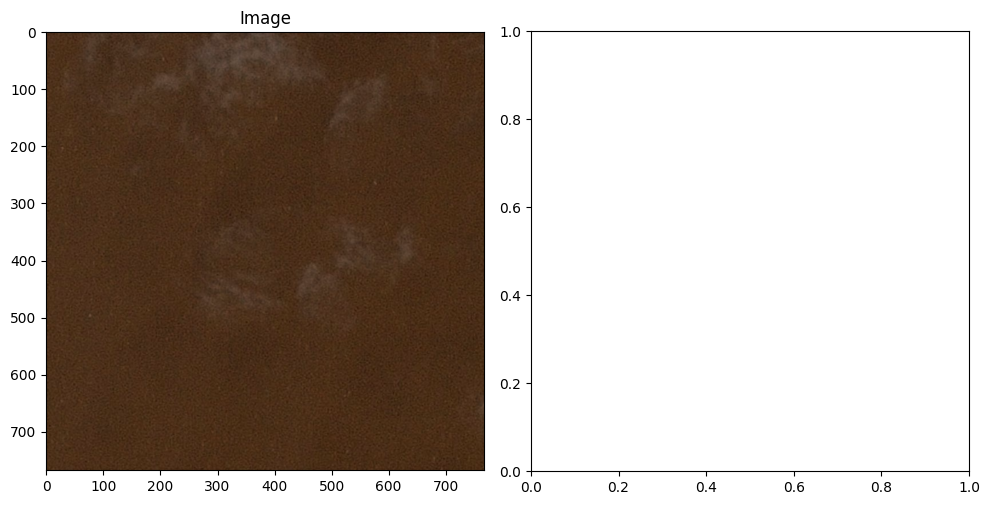

In [29]:
show_image_with_n_ships(0, segmentations_df, grouped_segmentations_df)